In [1]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import math
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号 #有中文出现的情况

In [2]:
def sigmoid(x):
    t = 1 + np.exp(-x)
    result = np.divide(1,t)
    return result

def l1_logit_func(X,y,theta,lamb,mu,sig):
    ''' 
    :param X: 待输入的数据特征
    :param y: 待输入的数据标签
    :param theta: 待估计的参数向量（logit回归参数）
    :param lamb: L1正则的超参数
    :param mu: 先验正态分布的均值
    :param sig: 先验正态分布的协方差矩阵的对角元素
    '''
    data_len = X.shape[0]  #样本量n
    feature_len = theta.shape[0]  #特征数p
    j_ = 1
    for i in range(data_len):
        t1 = np.dot(X[i], theta) 
        h_theta = sigmoid(t1)
        h_ = pow(h_theta,y[i])*pow(1-h_theta,1-y[i])
        j_ = j_*h_
    
    k_ = 1
    for j in range(feature_len):
        p_ = np.exp(-np.abs(theta[j]-mu[j])/sig[j])/(2*sig[j])
        k_ = k_*p_

    dis = j_*k_
    return dis

def l2_logit_func(X,y,theta,lamb,mu,sig):
    ''' 
    :param X: 待输入的数据特征
    :param y: 待输入的数据标签
    :param theta: 待估计的参数向量（logit回归参数）
    :param lamb: L1正则的超参数
    :param mu: 先验正态分布的均值
    :param sig: 先验正态分布的协方差矩阵的对角元素
    '''
    data_len = X.shape[0]  #样本量n
    feature_len = theta.shape[0]  #特征数p
    j_ = 1
    for i in range(data_len):
        t1 = np.dot(X[i], theta) 
        h_theta = sigmoid(t1)
        h_ = pow(h_theta,y[i])*pow(1-h_theta,1-y[i])
        j_ = j_*h_
    
    k_ = 1
    for j in range(feature_len):
        p_ = np.exp(-pow(theta[j]-mu[j],2)/(2*pow(sig[j],2)))/(math.sqrt(2*math.pi)*sig[j])
        k_ = k_*p_

    dis = j_*k_
    return dis

def l1_logit_mcmc(X,y,theta,lamb,Sigma,mu,sig,max_iter):
    
    ''' 
    :param X: 待输入的数据特征
    :param y: 待输入的数据标签
    :param theta: 待估计的参数向量（logit回归参数）
    :param lamb: L1正则的超参数
    :param sigma: 用于生成eps的多元正态分布的协方差矩阵
    :param mu: 先验正态分布的均值
    :param sig: 先验正态分布的协方差矩阵的对角元素
    :param max_iter: MCMC的最大迭代次数
    '''
    theta_list = []
    norm_list = []
    theta_list.append(theta)
    norm_list.append(np.linalg.norm(theta))
    accept = 0
    feature_len = theta.shape[0]  #特征数p
    for i in np.arange(1,max_iter):
        beta = np.random.multivariate_normal(theta_list[i-1],Sigma,size=1).squeeze()
        u = np.random.rand(1)
        judge = l1_logit_func(X,y,beta,lamb,mu,sig)/l1_logit_func(X,y,theta_list[i-1],lamb,mu,sig)
        prob = min(1,judge)
        if u <= prob:
            theta_list.append(beta)
            norm_list.append(np.linalg.norm(beta))
            accept += 1
        else:
            theta_list.append(theta_list[i-1])
            norm_list.append(np.linalg.norm(theta_list[i-1]))

    accept_rate = accept/max_iter
    theta_res = theta_list[-1]
    return theta_list,accept_rate,theta_res,norm_list

def l2_logit_mcmc(X,y,theta,lamb,Sigma,mu,sig,max_iter):
    
    ''' 
    :param X: 待输入的数据特征
    :param y: 待输入的数据标签
    :param theta: 待估计的参数向量（logit回归参数）
    :param lamb: L1正则的超参数
    :param sigma: 用于生成eps的多元正态分布的协方差矩阵
    :param mu: 先验正态分布的均值
    :param sig: 先验正态分布的协方差矩阵的对角元素
    :param max_iter: MCMC的最大迭代次数
    '''
    theta_list = []
    norm_list = []
    theta_list.append(theta)
    norm_list.append(np.linalg.norm(theta))
    accept = 0
    feature_len = theta.shape[0]  #特征数p
    for i in np.arange(1,max_iter):
        beta = np.random.multivariate_normal(theta_list[i-1],Sigma,size=1).squeeze()
        u = np.random.rand(1)
        judge = l2_logit_func(X,y,beta,lamb,mu,sig)/l2_logit_func(X,y,theta_list[i-1],lamb,mu,sig)
        prob = min(1,judge)
        if u <= prob:
            theta_list.append(beta)
            norm_list.append(np.linalg.norm(beta))
            accept += 1
        else:
            theta_list.append(theta_list[i-1])
            norm_list.append(np.linalg.norm(theta_list[i-1]))

    accept_rate = accept/max_iter
    theta_res = theta_list[-1]
    return theta_list,accept_rate,theta_res,norm_list

def predict(x_test,theta):
    """
    desc:根据传入的特征,利用模型预测数据
    """
    t = np.dot(x_test, theta)
    # 得出类别为 1 的概率
    result = sigmoid(t)
    # 将所有数据取整  p > 0.5 return: 1 , p <= 0.5 return: 0
    return np.round(result)


#### 用鸢尾花数据集验证

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
iris_data = np.column_stack(load_iris(return_X_y=True))
# 这里我们实现的只是二分类算法,左右只需要类别0和类别1两种即可
iris_data = iris_data[iris_data[:,-1]<2]
# 将数据打乱
np.random.shuffle(iris_data)
# 将数据分成两份
train_x,test_x,train_y,test_y = train_test_split(iris_data[:,:-1],iris_data[:,-1],test_size=0.3,random_state=2)

In [7]:
ini_theta = np.array([0]*train_x.shape[1],dtype=float)
sigma = np.eye(ini_theta.shape[0])
mu = np.array([0]*train_x.shape[1],dtype=float)
sig = np.array([1]*train_x.shape[1],dtype=float)
res = l1_logit_mcmc(train_x,train_y,theta=ini_theta,lamb=0.01,Sigma=sigma,mu=mu,sig=sig,max_iter=30000)
theta_res = res[2]
pred_y_l1 = predict(test_x,theta_res)

acc = accuracy_score(test_y,pred_y_l1)
rec = recall_score(test_y,pred_y_l1)
pre = precision_score(test_y,pred_y_l1)
f1 = f1_score(test_y,pred_y_l1)

print('预测准确率为:{:.4f}'.format(acc))
print('预测查准率为:{:.4f}'.format(pre))
print('预测召回率为:{:.4f}'.format(rec))
print('预测f1-score为:{:.4f}'.format(f1))
print('模型系数结果beta为',theta_res)

预测准确率为:1.0000
预测查准率为:1.0000
预测召回率为:1.0000
预测f1-score为:1.0000
模型系数结果beta为 [ 0.12863183 -2.15982922  0.50753011  6.33194141]


In [12]:
theta_list = res[0]
norm_list = res[3]
acc_mean_list = []
for i in range(len(norm_list)):
    acc_mean_list.append(np.mean(norm_list[0:i]))


e:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


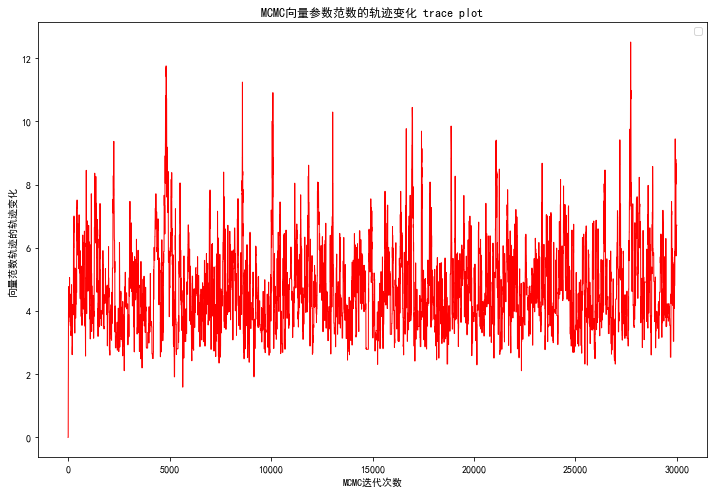

In [16]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),norm_list,color='red',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的轨迹变化')
plt.title('MCMC向量参数范数的轨迹变化 trace plot')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


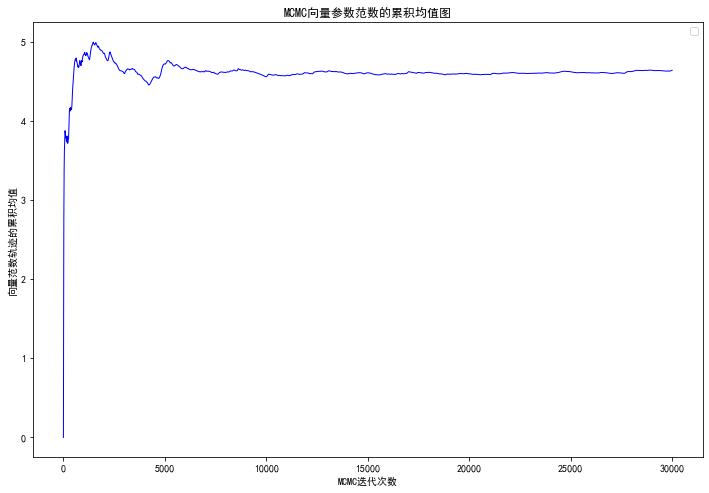

In [15]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),acc_mean_list,color='blue',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的累积均值')
plt.title('MCMC向量参数范数的累积均值图')
plt.legend()
plt.show()

In [17]:
ini_theta = np.array([0]*train_x.shape[1],dtype=float)
sigma = np.eye(ini_theta.shape[0])
mu = np.array([0]*train_x.shape[1],dtype=float)
sig = np.array([1]*train_x.shape[1],dtype=float)
res = l2_logit_mcmc(train_x,train_y,theta=ini_theta,lamb=0.01,Sigma=sigma,mu=mu,sig=sig,max_iter=30000)
theta_res = res[2]
pred_y_l2 = predict(test_x,theta_res)

acc = accuracy_score(test_y,pred_y_l2)
rec = recall_score(test_y,pred_y_l2)
pre = precision_score(test_y,pred_y_l2)
f1 = f1_score(test_y,pred_y_l2)

print('预测准确率为:{:.4f}'.format(acc))
print('预测查准率为:{:.4f}'.format(pre))
print('预测召回率为:{:.4f}'.format(rec))
print('预测f1-score为:{:.4f}'.format(f1))
print('模型系数结果beta为',theta_res)

预测准确率为:1.0000
预测查准率为:1.0000
预测召回率为:1.0000
预测f1-score为:1.0000
模型系数结果beta为 [-0.1071955  -1.0839796   1.15499659  2.48272203]


In [18]:
theta_list = res[0]
norm_list = res[3]
acc_mean_list = []
for i in range(len(norm_list)):
    acc_mean_list.append(np.mean(norm_list[0:i]))

e:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


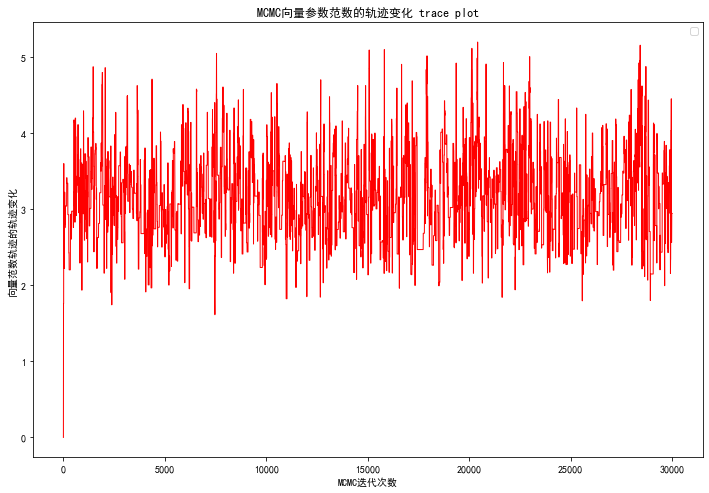

In [19]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),norm_list,color='red',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的轨迹变化')
plt.title('MCMC向量参数范数的轨迹变化 trace plot')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


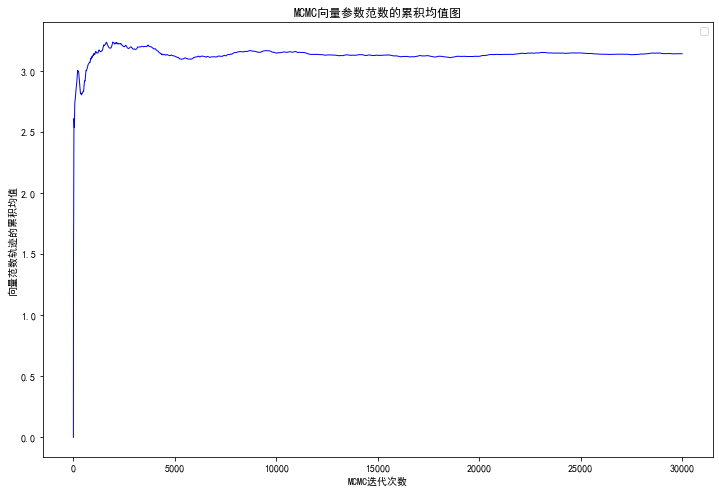

In [20]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),acc_mean_list,color='blue',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的累积均值')
plt.title('MCMC向量参数范数的累积均值图')
plt.legend()
plt.show()

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

lr_l1 = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)
lr_l1.fit(train_x,train_y)
pred_y_lr = lr_l1.predict(test_x)

acc = accuracy_score(test_y,pred_y_lr)
rec = recall_score(test_y,pred_y_lr)
pre = precision_score(test_y,pred_y_lr)
f1 = f1_score(test_y,pred_y_lr)

print('预测准确率为:{:.4f}'.format(acc))
print('预测查准率为:{:.4f}'.format(pre))
print('预测召回率为:{:.4f}'.format(rec))
print('预测f1-score为:{:.4f}'.format(f1))

print(lr_l1.coef_)

预测准确率为:1.0000
预测查准率为:1.0000
预测召回率为:1.0000
预测f1-score为:1.0000
[[-0.38490612 -1.32996549  2.04858929  0.90421201]]


#### 用第五次作业数据集验证

In [21]:
data = pd.read_csv('data.csv')

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 训练数据
train_x = train_data.iloc[:,1:].values 
train_y = np.array(train_data.iloc[:,0])
# 测试数据
test_x = test_data.iloc[:,1:].values
test_y = np.array(test_data.iloc[:,0])

In [22]:
ini_theta = np.array([0]*train_x.shape[1],dtype=float)
sigma = np.eye(ini_theta.shape[0])
mu = np.array([0]*train_x.shape[1],dtype=float)
sig = np.array([1]*train_x.shape[1],dtype=float)
res = l1_logit_mcmc(train_x,train_y,theta=ini_theta,lamb=0.01,Sigma=sigma,mu=mu,sig=sig,max_iter=30000)
theta_res = res[2]
pred_y_l1 = predict(test_x,theta_res)

acc = accuracy_score(test_y,pred_y_l1)
rec = recall_score(test_y,pred_y_l1)
pre = precision_score(test_y,pred_y_l1)
f1 = f1_score(test_y,pred_y_l1)

print('预测准确率为:{:.4f}'.format(acc))
print('预测查准率为:{:.4f}'.format(pre))
print('预测召回率为:{:.4f}'.format(rec))
print('预测f1-score为:{:.4f}'.format(f1))
print('模型系数结果beta为',theta_res)

预测准确率为:0.7250
预测查准率为:0.7000
预测召回率为:0.7368
预测f1-score为:0.7179
模型系数结果beta为 [ 1.033428    1.21801272  0.69592308 -0.86756089 -2.06083706]


In [23]:
theta_list = res[0]
norm_list = res[3]
acc_mean_list = []
for i in range(len(norm_list)):
    acc_mean_list.append(np.mean(norm_list[0:i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


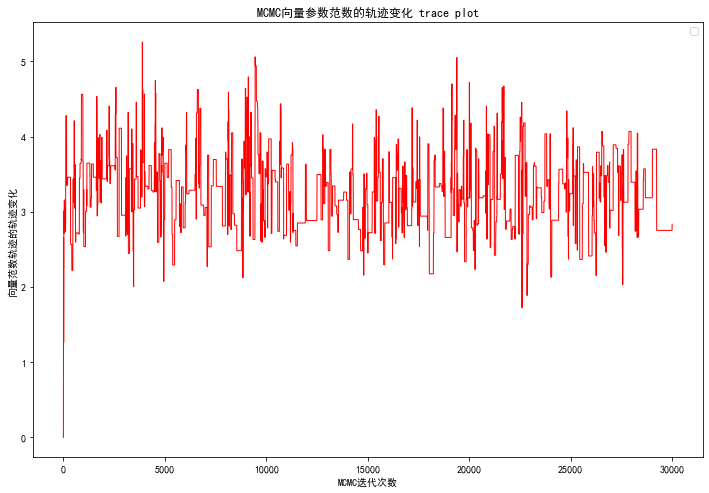

In [24]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),norm_list,color='red',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的轨迹变化')
plt.title('MCMC向量参数范数的轨迹变化 trace plot')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


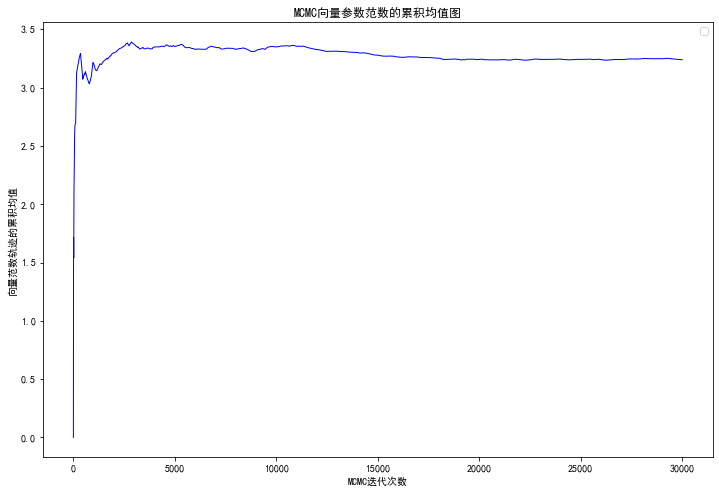

In [25]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),acc_mean_list,color='blue',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的累积均值')
plt.title('MCMC向量参数范数的累积均值图')
plt.legend()
plt.show()

In [26]:
ini_theta = np.array([0]*train_x.shape[1],dtype=float)
sigma = np.eye(ini_theta.shape[0])
mu = np.array([0]*train_x.shape[1],dtype=float)
sig = np.array([1]*train_x.shape[1],dtype=float)
res = l2_logit_mcmc(train_x,train_y,theta=ini_theta,lamb=0.01,Sigma=sigma,mu=mu,sig=sig,max_iter=30000)
theta_res = res[2]
pred_y_l2 = predict(test_x,theta_res)

acc = accuracy_score(test_y,pred_y_l2)
rec = recall_score(test_y,pred_y_l2)
pre = precision_score(test_y,pred_y_l2)
f1 = f1_score(test_y,pred_y_l2)

print('预测准确率为:{:.4f}'.format(acc))
print('预测查准率为:{:.4f}'.format(pre))
print('预测召回率为:{:.4f}'.format(rec))
print('预测f1-score为:{:.4f}'.format(f1))
print('模型系数结果beta为',theta_res)

预测准确率为:0.7000
预测查准率为:0.6842
预测召回率为:0.6842
预测f1-score为:0.6842
模型系数结果beta为 [ 0.87454879  1.1422961   0.65039379 -1.2454954  -2.05993192]


In [27]:
theta_list = res[0]
norm_list = res[3]
acc_mean_list = []
for i in range(len(norm_list)):
    acc_mean_list.append(np.mean(norm_list[0:i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


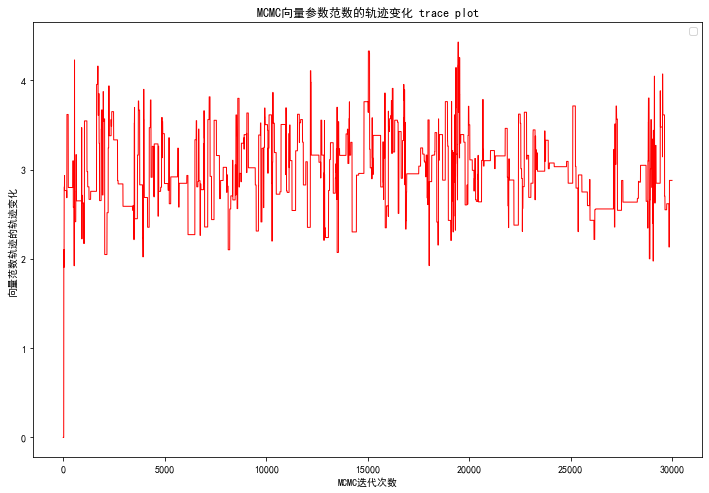

In [28]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),norm_list,color='red',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的轨迹变化')
plt.title('MCMC向量参数范数的轨迹变化 trace plot')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


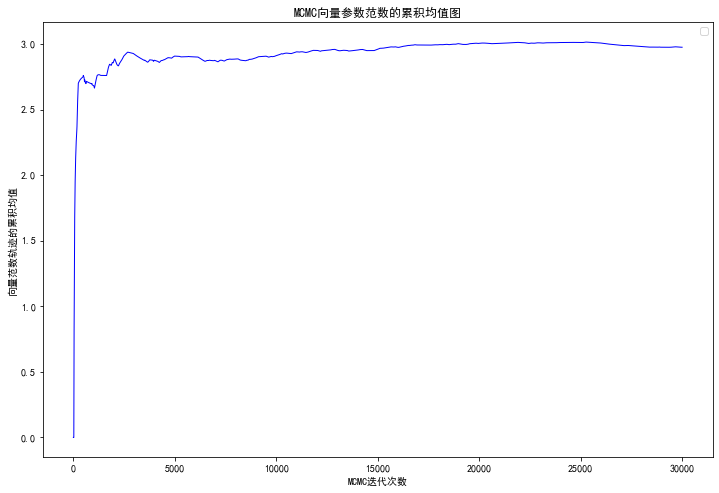

In [29]:
plt.figure(figsize=(12,8))
plt.plot(range(len(norm_list)),acc_mean_list,color='blue',linewidth=1)
plt.xlabel('MCMC迭代次数')
plt.ylabel('向量范数轨迹的累积均值')
plt.title('MCMC向量参数范数的累积均值图')
plt.legend()
plt.show()

In [51]:
from sklearn.linear_model import LogisticRegression

lr_l1 = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
lr_l1.fit(train_x,train_y)
pred_y_lr = lr_l1.predict(test_x)

acc = accuracy_score(test_y,pred_y_lr)
rec = recall_score(test_y,pred_y_lr)
pre = precision_score(test_y,pred_y_lr)
f1 = f1_score(test_y,pred_y_lr)

print('预测准确率为:{:.4f}'.format(acc))
print('预测查准率为:{:.4f}'.format(pre))
print('预测召回率为:{:.4f}'.format(rec))
print('预测f1-score为:{:.4f}'.format(f1))

print(lr_l1.coef_)

预测准确率为:0.7250
预测查准率为:0.6667
预测召回率为:0.8421
预测f1-score为:0.7442
[[ 1.20301627  1.42349859  0.40411076 -1.10694088 -1.98583569]]
